In [1]:
#!pip install beautifulsoup4

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import scipy.stats as stats

In [3]:
#Extract list of neighborhoods from Wikipedia page
wiki_link = 'https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego'
raw_wiki = requests.get(wiki_link).text

#Import and parse the text from Wikipedia using BeautifulSoup
soup = BeautifulSoup(raw_wiki,'lxml')

In [4]:
#Data of the neighborhoods is inside an html <table> object.
soup_table = soup.table
#Decompose the <div> object inside the table to clean our data
soup_table.div.decompose()
soup_table

<table class="multicol" role="presentation" style="border-collapse: collapse; padding: 0; border: 0; background:transparent; width:100%;"><tbody><tr>
<td style="text-align: left; vertical-align: top;">
<ul><li><a class="mw-redirect" href="/wiki/Balboa_Park,_San_Diego" title="Balboa Park, San Diego">Balboa Park</a></li>
<li><a href="/wiki/Bankers_Hill,_San_Diego" title="Bankers Hill, San Diego">Bankers Hill</a></li>
<li><a href="/wiki/Barrio_Logan,_San_Diego" title="Barrio Logan, San Diego">Barrio Logan</a></li>
<li><a class="mw-redirect" href="/wiki/Bay_Ho,_San_Diego" title="Bay Ho, San Diego">Bay Ho</a></li>
<li><a class="mw-redirect" href="/wiki/Bay_Park,_San_Diego" title="Bay Park, San Diego">Bay Park</a></li>
<li><a href="/wiki/Birdland,_San_Diego" title="Birdland, San Diego">Birdland</a></li>
<li><a href="/wiki/Black_Mountain_Ranch,_San_Diego" title="Black Mountain Ranch, San Diego">Black Mountain Ranch</a></li>
<li><a class="mw-redirect" href="/wiki/Border,_San_Diego" title="Bord

In [5]:
#Loop through the soup object to extract names of neighborhoods
neighborhoods = []

for name in soup_table.find_all('a'):
    neighborhoods.append(str(name.string))
    
print('There are ',len(neighborhoods),' neighborhoods in San Diego, CA.')

There are  126  neighborhoods in San Diego, CA.


In [6]:
#import Nominatim to get location data on the neighborhoods
from geopy.geocoders import Nominatim

In [7]:
#from geopy.exc import GeocoderTimedOut #Use this if Geocode 

def locationfinder(neighborhoods):
    geolocator = Nominatim(user_agent='kkha@lab-data.com')
    locations = []
    for nbhd in neighborhoods:
        address = nbhd + ', San Diego, CA'
        location = geolocator.geocode(address)
        if location is None:
            pass
        else:
            x = [nbhd, location.latitude, location.longitude]
            locations.append(x)
    return(locations)

In [8]:
import pickle

#check if locations pickle created, will load in data if we've already created it before
try:
    with open('locations.pkl', 'rb') as f:
        locations = pickle.load(f)
    print('Data loaded.')
except:
    locations = locationfinder(neighborhoods)
    
#with open('locations.pkl', 'wb') as f:
#    pickle.dump(locations, f)

locations[0:5]

Data loaded.


[['Balboa Park', 32.73135675, -117.146526555704],
 ['Bankers Hill', 32.728293, -117.1621052],
 ['Barrio Logan', 32.6938863, -117.1380068],
 ['Bay Park', 32.7846385, -117.2026047],
 ['Birdland', 32.7923329, -117.1542061]]

Now that we have our neighborhoods loaded in and found their latitudes and longitudes, we can import them into a Pandas DataFrame to make it easier for analysis.

In [9]:
df_loc = pd.DataFrame(data=locations)
df_loc.columns = ['Neighborhood', 'Latitude', 'Longitude']

#we see we have NaN values, let's drop these.
df_loc.dropna(axis=0, inplace=True)

Let's begin to map out where the neighborhoods are to get a feel of what our clusters will be like. 

In [10]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [11]:
geolocator = Nominatim(user_agent='kevinle.kha@gmail.com')
sd_loc = geolocator.geocode('San Diego, CA')
sd_lat = sd_loc.latitude
sd_lng = sd_loc.longitude

map_SD = folium.Map(location=(sd_lat,sd_lng), zoom_start=10)

for nbhd, lat, lng in zip(df_loc['Neighborhood'], df_loc['Latitude'], df_loc['Longitude']):
    label = '{}, San Diego, CA'.format(nbhd)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=False).add_to(map_SD)
    
map_SD

You may be wondering why there are no marked neighborhoods between the larger group and smaller group near the border of Mexico. That area is the city of Chula Vista, which does not fall in the jurisdiction of San Diego, therefore is not included in this data.

Awesome! Now that we have the neighborhoods mapped out, let's begin to use our knowledge of Foursquare API to collect restaurant venues from within the neighborhoods. This will help us 

In [12]:
#Establish Foursquare credentials and version
CLIENT_ID = 'GBJAVVUEQROJMXHD1NIDQPJX5D1RF3WEBS0Y4JWDC2SCAX5A' # your Foursquare ID
CLIENT_SECRET = 'DYQ4XQKT5OFYARVZB0DJXR3PZ5PEE2R3U5OJ0UB1EDZCVANR' # your Foursquare Secret
VERSION = '20190321' # Foursquare API version

In [15]:
def getNearbyFoods(names, latitudes, longitudes, radius=5000, LIMIT=100):
    
    food_cat = '4d4b7105d754a06374d81259'
    rest_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT,
            food_cat)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        rest_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_foods = pd.DataFrame([item for rest_list in rest_list for item in rest_list])
    nearby_foods.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_foods)

In [19]:
#check if restaurant data pickle created, will load in data if we've already created it before
try:
    with open('sd_rests.pkl', 'rb') as f:
        sd_rests = pickle.load(f)
    print('Data loaded.')
except:
    sd_rests = getNearbyFoods(names=df_loc['Neighborhood'],
                            latitudes = df_loc['Latitude'],
                            longitudes = df_loc['Longitude'])

#with open('sd_rests.pkl', 'wb') as f:
#    pickle.dump(sd_rests, f)


Data loaded.


In [17]:
print(sd_rests.shape)
sd_rests.head()

(10883, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Balboa Park,32.731357,-117.146527,The Prado at Balboa Park,32.731042,-117.149792,American Restaurant
1,Balboa Park,32.731357,-117.146527,Panama 66,32.731770,-117.151081,Gastropub
2,Balboa Park,32.731357,-117.146527,CUCINA urbana,32.731278,-117.160189,Italian Restaurant
3,Balboa Park,32.731357,-117.146527,Azuki Sushi,32.729665,-117.160119,Sushi Restaurant
4,Balboa Park,32.731357,-117.146527,Mister A's,32.731900,-117.160425,Restaurant


In [20]:
sd_rests.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allied Gardens,100,100,100,100,100,100
Alta Vista,100,100,100,100,100,100
Balboa Park,100,100,100,100,100,100
Bankers Hill,100,100,100,100,100,100
Barrio Logan,100,100,100,100,100,100
Bay Park,100,100,100,100,100,100
Bay Terraces,82,82,82,82,82,82
Birdland,100,100,100,100,100,100
Black Mountain Ranch,96,96,96,96,96,96


In [21]:
print('There are {} unique restaurant categories.'.format(len(sd_rests['Venue Category'].unique())))

There are 89 uniques categories.


In [22]:
#one hot encoding
sd_onehot = pd.get_dummies(sd_rests[['Venue Category']], prefix="", prefix_sep="")

#add neighborhoods column back to dataframe
sd_onehot['Neighborhood'] = sd_rests['Neighborhood']

#move neighborhood column to first column
fixed_columns = [sd_onehot.columns[-1]] + list(sd_onehot.columns[:-1])
sd_onehot = sd_onehot[fixed_columns]

sd_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Balboa Park,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balboa Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
sd_grouped = sd_onehot.groupby('Neighborhood').mean().reset_index()
sd_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allied Gardens,0.00,0.030000,0.00,0.000000,0.000000,0.020000,0.000000,0.00,0.00,...,0.020000,0.00,0.00,0.01,0.050000,0.00,0.00,0.010000,0.060000,0.020000
1,Alta Vista,0.00,0.020000,0.00,0.030000,0.020000,0.000000,0.050000,0.00,0.00,...,0.050000,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.030000,0.030000
2,Balboa Park,0.00,0.090000,0.00,0.000000,0.010000,0.000000,0.010000,0.00,0.01,...,0.030000,0.00,0.00,0.00,0.040000,0.00,0.00,0.040000,0.000000,0.000000
3,Bankers Hill,0.00,0.080000,0.00,0.000000,0.000000,0.000000,0.010000,0.00,0.01,...,0.040000,0.00,0.00,0.00,0.010000,0.01,0.00,0.030000,0.000000,0.000000
4,Barrio Logan,0.00,0.060000,0.00,0.010000,0.010000,0.000000,0.010000,0.00,0.01,...,0.040000,0.00,0.01,0.00,0.020000,0.01,0.00,0.010000,0.000000,0.000000
5,Bay Park,0.00,0.060000,0.00,0.000000,0.040000,0.010000,0.020000,0.00,0.01,...,0.030000,0.00,0.00,0.00,0.040000,0.00,0.00,0.000000,0.020000,0.000000
6,Bay Terraces,0.00,0.012195,0.00,0.060976,0.036585,0.000000,0.048780,0.00,0.00,...,0.048780,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.012195,0.048780
7,Birdland,0.00,0.060000,0.01,0.000000,0.010000,0.010000,0.050000,0.00,0.00,...,0.010000,0.00,0.00,0.00,0.050000,0.00,0.01,0.020000,0.020000,0.010000
8,Black Mountain Ranch,0.00,0.010417,0.00,0.020833,0.010417,0.010417,0.020833,0.00,0.00,...,0.000000,0.00,0.00,0.00,0.020833,0.00,0.00,0.000000,0.010417,0.000000
9,Border,0.00,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.00,0.00,...,0.070000,0.00,0.00,0.00,0.000000,0.00,0.00,0.010000,0.010000,0.000000


In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sd_grouped['Neighborhood']

for ind in np.arange(sd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Allied Gardens,Mexican Restaurant,Pizza Place,Sandwich Place,Italian Restaurant,Vietnamese Restaurant,Café,Thai Restaurant,Burger Joint,American Restaurant,Fried Chicken Joint
1,Alta Vista,Mexican Restaurant,Pizza Place,Fried Chicken Joint,Sandwich Place,Fast Food Restaurant,Chinese Restaurant,Bakery,Taco Place,Filipino Restaurant,Wings Joint
2,Balboa Park,Italian Restaurant,American Restaurant,Café,Pizza Place,Mexican Restaurant,Breakfast Spot,New American Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Deli / Bodega
3,Bankers Hill,Italian Restaurant,American Restaurant,Café,Mexican Restaurant,Pizza Place,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Breakfast Spot,Taco Place
4,Barrio Logan,Mexican Restaurant,Italian Restaurant,Café,Steakhouse,Seafood Restaurant,New American Restaurant,American Restaurant,Breakfast Spot,Taco Place,Burger Joint


In [28]:
sd_grouped_clustering = sd_grouped.drop('Neighborhood', 1)

In [26]:
from sklearn.cluster import KMeans

Before we use K-Means, we should try to find the optimal K to use for our clustering.

In [29]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sd_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [30]:
import matplotlib.pyplot as plt

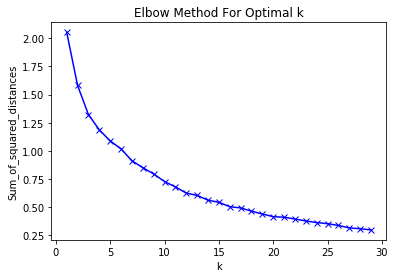

In [31]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In our Elbow method, we see that K will continuously decrease so we will arbitrarily set cluster limit to 10. That is when the changes sum of squared distances becomes negligible.

In [32]:
#set number of clusters
kclusters = 10

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sd_grouped_clustering)

kmeans.labels_[0:10]

array([1, 3, 0, 0, 0, 5, 3, 9, 2, 6])

In [33]:
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_

In [34]:
sd_merged = df_loc
sd_merged = sd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on ='Neighborhood', how='right')

sd_merged.head()

,Neighborhood,Latitude,Longitude,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant,Cluster Labels
0,Balboa Park,32.731357,-117.146527,Italian Restaurant,American Restaurant,Café,Pizza Place,Mexican Restaurant,Breakfast Spot,New American Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Deli / Bodega,0
1,Bankers Hill,32.728293,-117.162105,Italian Restaurant,American Restaurant,Café,Mexican Restaurant,Pizza Place,New American Restaurant,Seafood Restaurant,Sushi Restaurant,Breakfast Spot,Taco Place,0
2,Barrio Logan,32.693886,-117.138007,Mexican Restaurant,Italian Restaurant,Café,Steakhouse,Seafood Restaurant,New American Restaurant,American Restaurant,Breakfast Spot,Taco Place,Burger Joint,0
3,Bay Park,32.784638,-117.202605,Mexican Restaurant,Pizza Place,Sushi Restaurant,American Restaurant,Sandwich Place,Café,Breakfast Spot,Italian Restaurant,Thai Restaurant,BBQ Joint,5
4,Birdland,32.792333,-117.154206,Japanese Restaurant,Mexican Restaurant,American Restaurant,Thai Restaurant,Pizza Place,Burger Joint,Sushi Restaurant,Bakery,Chinese Restaurant,Sandwich Place,9


In [35]:
#import plot colors
import matplotlib.cm as cm
import matplotlib.colors as colors

In [36]:
# create map
map_clusters = folium.Map(location=[sd_lat, sd_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.jet(np.linspace(0, 1, len(ys)))
jet = [colors.to_hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sd_merged['Latitude'], sd_merged['Longitude'], sd_merged['Neighborhood'], sd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=jet[cluster-1],
        fill=True,
        fill_color=jet[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's look at how many neighborhoods are in each cluster

In [53]:
sd_merged[['Neighborhood','Cluster Labels']].groupby('Cluster Labels').count().sort_values(['Neighborhood'], ascending=False)

,Neighborhood
Cluster Labels,
0,21
1,18
5,18
3,14
7,11
2,10
8,9
9,6
6,4


We see that the 3 clusters with the most neighborhoods are Clusters 0, 1, and 5.

Now we can dive deeper into each cluster to find which cluster is the most diverse.

In [38]:
#Create a new dataframe of only Neighborhood, Venue Category, and Cluster Labels
sd_rests_cat = pd.DataFrame(data=sd_rests[['Neighborhood','Venue Category']])

#Create a dictionary that maps each neighborhood to its assigned cluster from K-Means
cluster_nbhd = sd_merged[['Neighborhood', 'Cluster Labels']]
nbhd_cluster_dict = dict(zip(cluster_nbhd['Neighborhood'], cluster_nbhd['Cluster Labels']))
nbhd_cluster_dict

#Map the dictionary to our new dataframe
sd_rests_cat['Cluster Labels'] = sd_rests_cat['Neighborhood'].map(nbhd_cluster_dict)
sd_rests_cat.head()

,Neighborhood,Venue Category,Cluster Labels
0,Balboa Park,American Restaurant,0
1,Balboa Park,Gastropub,0
2,Balboa Park,Italian Restaurant,0
3,Balboa Park,Sushi Restaurant,0
4,Balboa Park,Restaurant,0


In [68]:
c_list = list(np.arange(0,10,1))
c_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [60]:
sd_rests_cat.groupby(['Cluster Labels', 'Venue Category']).count()

Neighborhood
Cluster Labels Venue Category                             
0              American Restaurant                     190
               Asian Restaurant                         17
               BBQ Joint                                10
               Bakery                                    5
               Brazilian Restaurant                     21
               Breakfast Spot                           99
               Burger Joint                             65
               Café                                    184
               Chinese Restaurant                        2
               Deli / Bodega                            37
               Donut Shop                               22
               Falafel Restaurant                       18
               Fast Food Restaurant                      1
               Fondue Restaurant                        13
               Food Truck                               17
               French Restaurant                        21
               Fried Chicken Joint                      12
               Gastropub                                90
               Greek Restaurant                          4
               Hot Dog Joint                            21
               Irish Pub                                17
               Italian Restaurant                      218
               Japanese Restaurant                      12
               Mexican Restaurant                      207
               Middle Eastern Restaurant                 1
               New American Restaurant                  93
               Pizza Place                             108
               Poke Place                                1
               Ramen Restaurant                         25
               Restaurant                               26
...                                                    ...
9              Greek Restaurant                          3
               Hawaiian Restaurant                       1
               Hotpot Restaurant                         7
               Hunan Restaurant                          1
               Indian Restaurant                         4
               Italian Restaurant                        9
               Japanese Restaurant                      49
               Jewish Restaurant                         1
               Korean Restaurant                        30
               Latin American Restaurant                 1
               Mediterranean Restaurant                 11
               Mexican Restaurant                       46
               Middle Eastern Restaurant                10
               New American Restaurant                   3
               Noodle House                             17
               Pizza Place                              25
               Poke Place                               10
               Ramen Restaurant                         18
               Restaurant                                4
               Salad Place                               6
               Sandwich Place                           34
               Seafood Restaurant                       19
               Steakhouse                                5
               Sushi Restaurant                         37
               Taco Place                                3
               Thai Restaurant                          23
               Udon Restaurant                           5
               Vegetarian / Vegan Restaurant             6
               Vietnamese Restaurant                    18
               Wings Joint                               3

[467 rows x 1 columns]

In [89]:
d = {c: pd.DataFrame() for c in c_list}
df = {c: pd.DataFrame() for c in c_list}

In [90]:
d[0] = sd_rests_cat.loc[sd_rests_cat['Cluster Labels'] == 0].drop('Cluster Labels',1)

In [91]:
for c in c_list:
    d[c] = sd_rests_cat.loc[sd_rests_cat['Cluster Labels'] == c].drop('Cluster Labels',1).reset_index(drop=True)

In [92]:
d[0].head()

,Neighborhood,Venue Category
0,Balboa Park,American Restaurant
1,Balboa Park,Gastropub
2,Balboa Park,Italian Restaurant
3,Balboa Park,Sushi Restaurant
4,Balboa Park,Restaurant


In [93]:
for c in c_list:
    df[c] = d[c].groupby('Venue Category').count()

In [111]:
clusters

NameError: name 'clusters' is not defined

In [39]:
#Create dataframes of each cluster
cluster0 = sd_rests_cat.loc[sd_rests_cat['Cluster Labels'] == 0].drop('Cluster Labels',1)
cluster1 = sd_rests_cat.loc[sd_rests_cat['Cluster Labels'] == 1].drop('Cluster Labels',1)
cluster5 = sd_rests_cat.loc[sd_rests_cat['Cluster Labels'] == 5].drop('Cluster Labels',1)

In [41]:
cluster0_rest_tot = cluster0.groupby('Venue Category').count()
cluster1_rest_tot = cluster1.groupby('Venue Category').count()
cluster5_rest_tot = cluster5.groupby('Venue Category').count()

In [96]:
from functools import reduce

dfct = reduce(lambda x,y: pd.merge(x,y, on='Venue Category', how='outer'), [df[c] for c in c_list])

In [123]:
string = 'Cluster '
clusters = list(map(str, range(0, 10)))
cluster_list = [string + c for c in clusters]
cluster_list

['Cluster 0',
 'Cluster 1',
 'Cluster 2',
 'Cluster 3',
 'Cluster 4',
 'Cluster 5',
 'Cluster 6',
 'Cluster 7',
 'Cluster 8',
 'Cluster 9']

In [110]:
type(c_list[1])

numpy.int32

In [127]:
dfct.columns = cluster_list
dfct.fillna(value=0, inplace=True)

In [128]:
dfct

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
Venue Category,,,,,,,,,,
American Restaurant,190.0,75.0,23.0,23.0,1.0,110.0,2.0,129.0,40.0,13.0
Asian Restaurant,17.0,8.0,20.0,22.0,0.0,12.0,6.0,0.0,17.0,8.0
BBQ Joint,10.0,26.0,21.0,31.0,0.0,35.0,0.0,10.0,9.0,3.0
Bakery,5.0,19.0,31.0,38.0,0.0,57.0,3.0,22.0,25.0,21.0
Brazilian Restaurant,21.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
Breakfast Spot,99.0,64.0,23.0,24.0,0.0,86.0,11.0,62.0,19.0,9.0
Burger Joint,65.0,79.0,29.0,26.0,0.0,62.0,6.0,45.0,20.0,24.0
Café,184.0,90.0,10.0,20.0,1.0,94.0,35.0,64.0,37.0,7.0
Chinese Restaurant,2.0,51.0,52.0,69.0,0.0,11.0,8.0,16.0,21.0,22.0
